# Backward Simulation for Inferring Hidden Biomolecular Kinetic Profiles 
### Junghun Chae, Roktaek Lim, Cheol-Min Ghim, and Pan-Jun Kim

### System requirements 
- Windows, Linux, or macOS 
- Python 3.7 or later 

### Required modules 
- SciPy 
- Matplotlib 
- NumPy 
- random

### General information 
The protein degradation model from Lim et al. (2021) when the protein abundance profile x(t) is maintained. These codes solve the protein degradation model when phosphorylation is not involved. 

### References 
Lim, R., Chae, J., Somers, D.E., Ghim, C.-M., and Kim, P.-J. (2021). 
Cost-effective circadian mechanism: rhythmic degradation of circadian proteins 
spontaneously emerges without rhythmic post-translational regulation. 
iScience 24, 102726.

### Contact information
This code was written by Junghun Chae.
If you have any questions, please contact J. Chae by "wjdgnswkd612@gmail.com".

### Import modules

In [1]:
#-*-coding: utf-8 -*-

In [2]:
from scipy.integrate import solve_ivp 
from scipy.interpolate import interp1d as inp1d
import matplotlib.pyplot as plt 
import numpy as np
import random as rd
import pandas as pd

### Read time-course data

In [3]:
file_name = "protein_profile.tsv"
data_df = pd.read_csv(file_name, sep = "\t")

In [4]:
t_series = data_df["t"]
p_series = data_df["protein"]

#### Check time series data

In [5]:
t_series

0       0.00
1       0.05
2       0.10
3       0.15
4       0.20
       ...  
476    23.80
477    23.85
478    23.90
479    23.95
480    24.00
Name: t, Length: 481, dtype: float64

In [6]:
t_period = 24
num_period = 15

t_series_long = []
p_series_long = []

for period_idx_temp in range(num_period):
    for t_idx_temp, t_temp in enumerate(t_series[:-1]):
        t_cur_temp = t_temp + t_period * period_idx_temp
        p_cur_temp = p_series[t_idx_temp]
        
        t_series_long.append(t_cur_temp)
        p_series_long.append(p_cur_temp)
    #
#   

p_interp = inp1d(t_series_long, p_series_long, kind = "cubic")

#### A module describing the system of ODEs. 

In [7]:
def equation_Full(y, t, para, Xprof):
    ### --- ODE systems.
    # input : 
    # y     - array of current elements 
    # t     - time 
    # para  - array of parameters 
    # Xprof - function that takes time and return total protein concentration 
    # ouput : 
    # dxvardt   - array of time derivatives of each element at given time t  

    dxvardt = np.zeros(4)

    a0 = para[0]
    a1 = para[1]
    a2 = para[2]
    b0 = para[3]
    b1 = para[4]
    q = para[5]
    s = para[6]
    r0 = para[7]
    U = para[8]
    V = para[9]

    substrate_sum=0
    for i in range(4):
        substrate_sum = substrate_sum + y[i]
    freex = Xprof(t) - substrate_sum

    xeo = y[0]; xeub = y[1]; xoub = y[2]; xhub = y[3]

    u = U - xeo - xeub
    v = V - xhub

    dxvardt[0] = a0*u*freex - a1*xeo - q*xeo

    dxvardt[1] = q*xeo + a0*u*xoub - a2*xeub - r0*xeub

    dxvardt[2] = a2*xeub - a0*u*xoub -b0*v*xoub + b1*xhub - r0*xoub

    dxvardt[3] = b0*v*xoub - b1*xhub - s*xhub - r0*xhub

    return dxvardt
# 

#### Class to store solutions

In [8]:
class Result:
    ### --- container for results 
    def __init__(self):
        self.feasible = True 
        self.t = 0 
        self.x0 = 0
        self.xe0 = 0 
        self.xeub = 0
        self.x0ub = 0 
        self.xhub = 0
        self.simulation_length = 0
    #
#

#### A module to solve the system of ODEs and process the solutions

In [9]:
def solve_ode(X, para = False, y0 = False, dt = 0.05, t_begin = 0, t_end = 24 * 10, solution_method = "RK45"):
    ### --- main function 
    # y0        - initial condition
    # dt        - time difference between time steps 
    # t_eval    - time points array to get ODE solutions 
    # para      - list container for parameters
    
    # --- parameter array 
    if not para:
        para = [0 for i in range(10)]
        a0 = para[0] = 10
        a1 = para[1] = 10
        a2 = para[2] = 10
        b0 = para[3] = 10
        b1 = para[4] = 10
        q = para[5] = 10
        s = para[6] = 10
        r0 = para[7] = 1
        u_bar = para[8] = 10
        v_bar = para[9] = 10
    else:
        a0 = para[0] 
        a1 = para[1] 
        a2 = para[2] 
        b0 = para[3] 
        b1 = para[4] 
        q = para[5] 
        s = para[6] 
        r0 = para[7] 
        u_bar = para[8] 
        v_bar = para[9] 
    #
    
    # --- initial conditions
    if not y0 : 
        y0 = [0, 0, 0, 0]

    simulation_length = t_end - t_begin
    t_eval = np.linspace(t_begin, t_end, int((t_end - t_begin)/dt) + 1)
    t_span = [t_eval[0], t_eval[-1]]

    xnew = solve_ivp(fun = lambda  t,y: equation_Full(y, t,  para, X),\
                    y0 = y0, t_eval = t_eval, t_span = t_span, method = solution_method, rtol=1e-7)

    t = xnew.t 
    xe0  = xnew.y[0]
    xeub = xnew.y[1]
    x0ub = xnew.y[2]
    xhub = xnew.y[3]

    # --- total X array 
    X_total = [] 
    for i in t:
        X_total.append(X(i))
    #
    X_total = np.array(X_total)

    # --- the concentration of free proteins without any modifications
    x0 = X_total - xe0 - xeub - x0ub - xhub

    # --- the concentration of ubiquitin ligases, not binding to their substrate proteins
    u = u_bar - xe0 - xeub

    # --- the concentration of deubiquitinating enzymes, not binding to their substrate proteins
    v = v_bar - xhub 

    # --- protein synthesis rate 
    # for 2nd order numerical derivatives, first and last 2 elements are disregarded. 
    g = []
    g.append(0.1)
    g.append(0.1)
    for i in range(2, len(t)-2):
        dt = t[i+1]-t[i]
        g.append(( -x0[i+2] + 8 * x0[i+1] - 8 * x0[i-1] \
                    + x0[i-2] ) / 12 / dt + a0 * u[i] * x0[i] - a1 * xe0[i] - s * xhub[i])
    #
    g.append(g[-1])
    g.append(g[-1])
    g = np.array(g)

    # --- Test physical constraints. 
    feasible = True 

    if min(x0) < 0 : 
        feasible = False 
    #
    if min(xe0) < 0 : 
        feasible = False 
    #
    if min(xeub) < 0 : 
        feasible = False 
    #
    if min(x0ub) < 0 : 
        feasible = False 
    #
    if min(xhub) < 0 : 
        feasible = False
    #
    if min(u) < 0 : 
        feasible = False 
    #
    if min(v) < 0 : 
        feasible = False 
    #
    if min(g) < 0 : 
        feasible = False 
    #

    res = Result()

    res.feasible = feasible

    if not feasible:
        return res
    else : 
        res.x0      = x0
        res.x0ub    = x0ub
        res.xe0     = xe0
        res.xeub    = xeub
        res.xhub    = xhub
        res.t       = t
        res.g       = g
        res.simulation_length  = simulation_length
        return res 
    #
#


#### Check how the system of ODEs behaves with different initial conditions
sol_list : (list) save solutions with different initial condtions. <br/>
num_initial_condition : the number of initial conditions to check. <br/>
ini_temp : temporal container for initial conditions. <br/>
res : temporal container for a solution.


In [10]:
sol_list = []
num_initial_condition = 5
for i in range(num_initial_condition):
    # --- give random initial condition
    ini_temp = []
    for j in range(4):
        ini_temp.append(rd.uniform(0,1))
    #
    
    # --- normalize with random protein concentration between 0 to 90% of total protein concentraion at t = 0. 
    total_concentration = rd.uniform(0, 0.9 * p_interp(0))
    norm_ini_temp = sum(ini_temp)
    for j in range(4):
        ini_temp[j] = ini_temp[j] / norm_ini_temp * total_concentration 
    #
    
    res = solve_ode(X = p_interp, y0 = ini_temp, dt = 0.005)
    sol_list.append(res)
# 

#### A module to check draw the solution behaves with different initial conditions
res_list : a list containing solutions.  <br/>
X : interpolation function of total protein concentration.  <br/>
r0 : maximum degradation rate.  <br/>
length : total number of period in the solution.  <br/>
num_period : number of period to draw the figure. <br/>
pop : whether to pop up the graph 
save_dir : directory to save figures. If the argument is False, it does not save figures.

In [11]:
def draw_different_intial(res_list, X, r0, length = 10, num_period = 3, pop = True, save_dir = False):
    ### --- draw time series of elements 
    # res_list      - list for Result container objects
    # length        - total simulation length
    # num_period    - number of period to show (from the beginning of simulation)
    # pop           - whether to pop up the graph 
    # save_dir      - if False, do not save the graph. To save graph, directory including file name should be given
    # the file name should end with ".png"

    for res_idx, res in enumerate(res_list):
        if not res.feasible :
            continue
        index_len = len(res.t)
        index_len_per_period = int(index_len / length)
        idx_end = int(index_len_per_period * num_period )
        plt.plot(res.t[ : idx_end ], res.x0[ : idx_end ], label = "initial condition x0(t) # " + str(res_idx))
    plt.legend()
    plt.grid()
    plt.xlabel("time [h]")
    plt.ylabel("Concentration [nM]")  
    if isinstance(save_dir, str):
        plt.savefig(save_dir.replace(".png", "_x0.png"))
    #
    if pop:
        plt.show()
    #
    plt.clf()
    plt.cla()
    plt.close("all")  

    for res_idx, res in enumerate(res_list):
        if not res.feasible :
            continue
        index_len = len(res.t)
        index_len_per_period = int(index_len / length)
        idx_end = int(index_len_per_period * num_period )
        plt.plot(res.t[ : idx_end], res.xe0[ : idx_end ], label = "initial condition xe0(t) # " + str(res_idx))
    plt.legend()
    plt.grid()
    plt.xlabel("time [h]")
    plt.ylabel("Concentration [nM]")  
    if isinstance(save_dir, str):
        plt.savefig(save_dir.replace(".png", "_xe0.png"))
    #
    if pop:
        plt.show()
    #
    plt.clf()
    plt.cla()
    plt.close("all")  

    for res_idx, res in enumerate(res_list):
        if not res.feasible :
            continue
        index_len = len(res.t)
        index_len_per_period = int(index_len / length)
        idx_end = int(index_len_per_period * num_period )
        plt.plot(res.t[ : idx_end ], res.xeub[ : idx_end ], label = "initial condition xEub(t) # " + str(res_idx))
    plt.legend()
    plt.grid()
    plt.xlabel("time [h]")
    plt.ylabel("Concentration [nM]")  
    if isinstance(save_dir, str):
        plt.savefig(save_dir.replace(".png", "_xeub.png"))
    #
    if pop:
        plt.show()
    #
    plt.clf()
    plt.cla()
    plt.close("all")  

    for res_idx, res in enumerate(res_list):
        if not res.feasible :
            continue
        index_len = len(res.t)
        index_len_per_period = int(index_len / length)
        idx_end = int(index_len_per_period * num_period )
        plt.plot(res.t[ : idx_end ], res.xhub[ : idx_end ], label = "initial condition xHub(t) # " + str(res_idx))
    plt.legend()
    plt.grid()
    plt.xlabel("time [h]")
    plt.ylabel("Concentration [nM]")  
    if isinstance(save_dir, str):
        plt.savefig(save_dir.replace(".png", "_xhub.png"))
    #
    if pop:
        plt.show()
    #
    plt.clf()
    plt.cla()
    plt.close("all")  
    
    for res_idx, res in enumerate(res_list):
        if not res.feasible :
            continue
        index_len = len(res.t)
        index_len_per_period = int(index_len / length)
        idx_end = int(index_len_per_period * num_period )
        plt.plot(res.t[ : idx_end ], r0 * ((res.x0ub + res.xeub + res.xhub)/(res.x0ub + res.xeub + res.xhub + res.x0 + res.xe0))[ : idx_end ], label = "initial condition r(t) # " + str(res_idx))
    plt.legend()
    plt.grid()
    plt.xlabel("time [h]")
    plt.ylabel("Degradation rate [nM/h]")  
    if isinstance(save_dir, str):
        plt.savefig(save_dir.replace(".png", "_rt.png"))
    #
    if pop:
        plt.show()
    #
    plt.clf()
    plt.cla()
    plt.close("all")  
    
    for res_idx, res in enumerate(res_list):
        if not res.feasible :
            continue
        index_len = len(res.t)
        index_len_per_period = int(index_len / length)
        idx_end = int(index_len_per_period * num_period )
        plt.plot(res.t[ : idx_end ], res.g[ : idx_end ], label = "initial condition g(t) # " + str(res_idx))
    plt.legend()
    plt.grid()
    plt.xlabel("time [h]")
    plt.ylabel("Protein synthesis rate [nM/h]")  
    if isinstance(save_dir, str):
        plt.savefig(save_dir.replace(".png", "_gt.png"))
    #
    if pop:
        plt.show()
    #
    plt.clf()
    plt.cla()
    plt.close("all")  

#

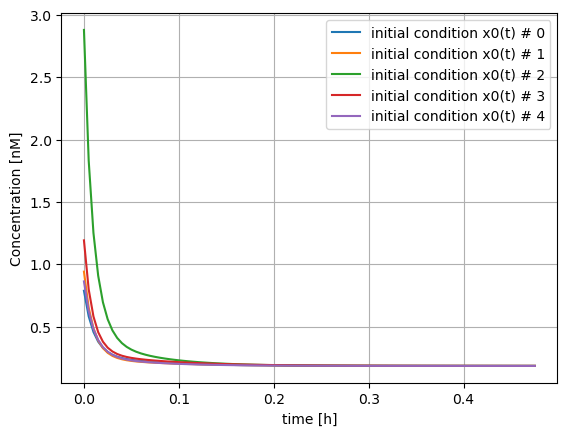

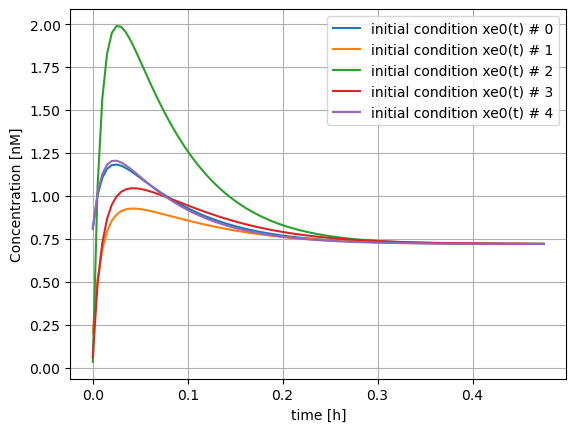

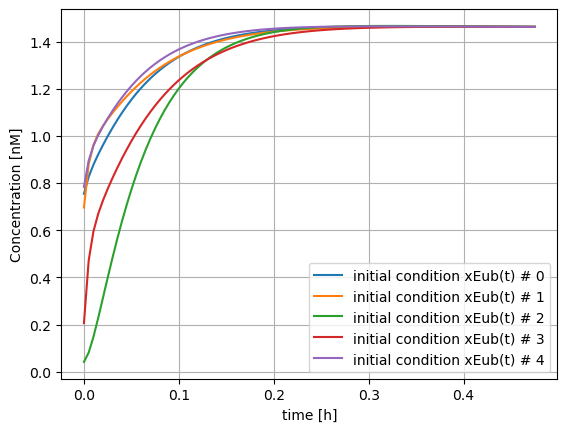

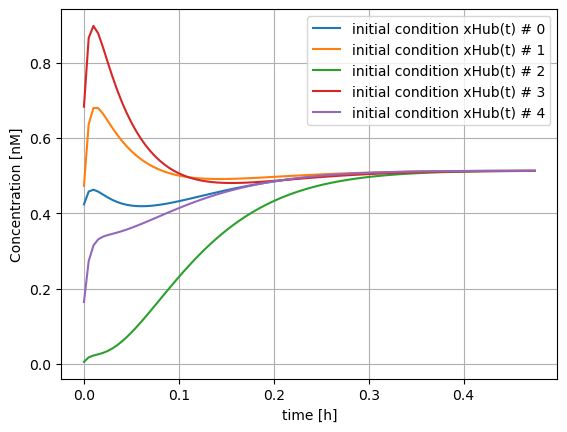

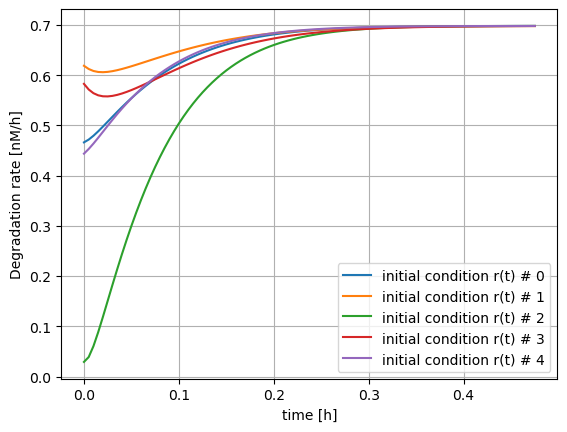

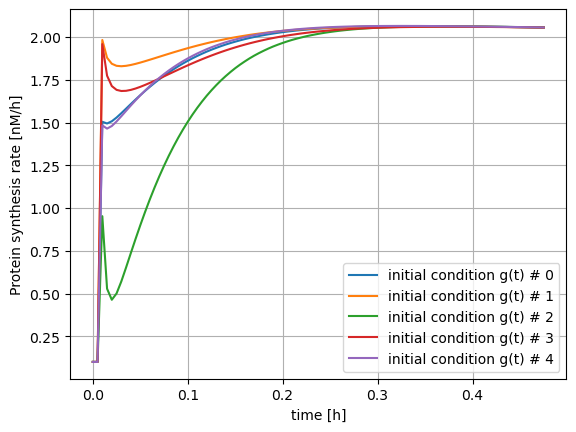

In [12]:
draw_different_intial(sol_list, X = p_interp, r0 = 1, num_period = 0.02, pop = True, save_dir = False)

#### With extreme parameter sets, check the behaviour of the solutions. 

V = 0 case
xHub will be 0


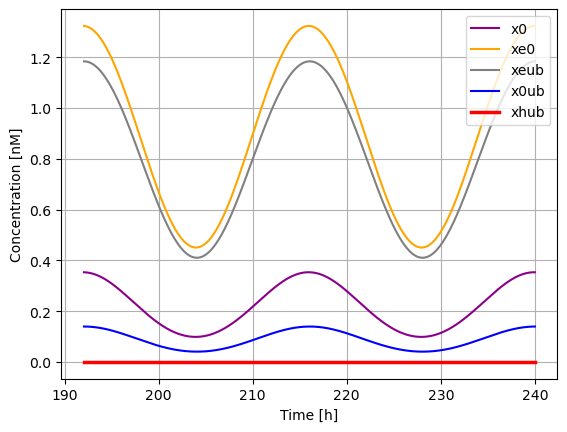

When a0*u and b0*v are much higher than a2*xeub, b1*xhub
x0ub will be very small


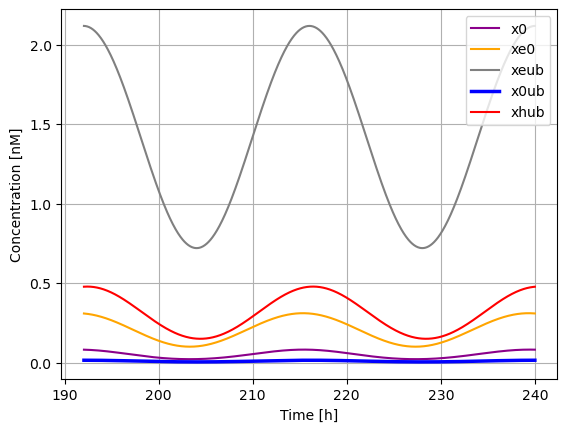

In [13]:
para = [0 for i in range(10)]
a0 = para[0] = 10
a1 = para[1] = 10
a2 = para[2] = 10
b0 = para[3] = 10
b1 = para[4] = 10
q = para[5] = 10
s = para[6] = 10
r0 = para[7] = 10
U = para[8] = 10
V = para[9] = 0
print("V = 0 case")
print("xHub will be 0")
res1 = solve_ode(X = p_interp, para = para)

index_len = len(res1.t)
length = 10
num_period = 2
index_len_per_period = int(index_len / length)
idx_end = int(index_len_per_period * num_period )

plt.plot(res1.t[-idx_end :], res1.x0[-idx_end :], label = "x0", color = "darkmagenta")
plt.plot(res1.t[-idx_end :], res1.xe0[-idx_end :], label = "xe0", color = "orange")
plt.plot(res1.t[-idx_end :], res1.xeub[-idx_end :], label = "xeub", color = "gray")
plt.plot(res1.t[-idx_end :], res1.x0ub[-idx_end :], label = "x0ub", color = "blue")
plt.plot(res1.t[-idx_end :], res1.xhub[-idx_end :], label = "xhub", color = "red", linewidth = 2.5)
plt.xlabel("Time [h]")
plt.ylabel("Concentration [nM]")
plt.grid()
plt.legend(loc = "upper right")
plt.show()

para = [0 for i in range(10)]
a0 = para[0] = 10
a1 = para[1] = 10
a2 = para[2] = 1
b0 = para[3] = 10
b1 = para[4] = 1
q = para[5] = 10
s = para[6] = 1
r0 = para[7] = 1
U = para[8] = 10
V = para[9] = 10
print("When a0*u and b0*v are much higher than a2*xeub, b1*xhub")
print("x0ub will be very small")

res2 = solve_ode(X = p_interp, para = para)

index_len = len(res2.t)
length = 10
num_period = 2
index_len_per_period = int(index_len / length)
idx_end = int(index_len_per_period * num_period )

plt.plot(res2.t[-idx_end :], res2.x0[-idx_end :], label = "x0", color = "darkmagenta")
plt.plot(res2.t[-idx_end :], res2.xe0[-idx_end :], label = "xe0", color = "orange")
plt.plot(res2.t[-idx_end :], res2.xeub[-idx_end :], label = "xeub", color = "gray")
plt.plot(res2.t[-idx_end :], res2.x0ub[-idx_end :], label = "x0ub", color = "blue", linewidth = 2.5)
plt.plot(res2.t[-idx_end :], res2.xhub[-idx_end :], label = "xhub", color = "red")
plt.xlabel("Time [h]")
plt.ylabel("Concentration [nM]")
plt.grid()
plt.legend(loc = "upper right")
plt.show()